In [ ]:
# author: Jana Lasser

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
from os.path import join
from PIL import Image

In [3]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

In [4]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"
demgrey = "#9EA4BF"
repgrey = "#BF9EA2"

In [6]:
dst = "../../plots"
src = "../../data"

# Main

## Fig 2: honesty score timelines

In [7]:
fname = "users.csv"
users = pd.read_csv(join(src, "users", fname))

In [8]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [9]:
fname = "belief.csv"
belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))

belief = belief_bootstrap[["year", "month", "avg_belief_score", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])
belief = belief.reset_index()
belief.columns = ["year", "month", "party", "belief_mean", 
                  "belief_perc_2.5", "belief_perc_97.5"]

In [10]:
fname = "truth.csv"
truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))

truth = truth_bootstrap[["year", "month", "avg_truth_score", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])
truth = truth.reset_index()
truth.columns = ["year", "month", "party", "truth_mean", 
                  "truth_perc_2.5", "truth_perc_97.5"]

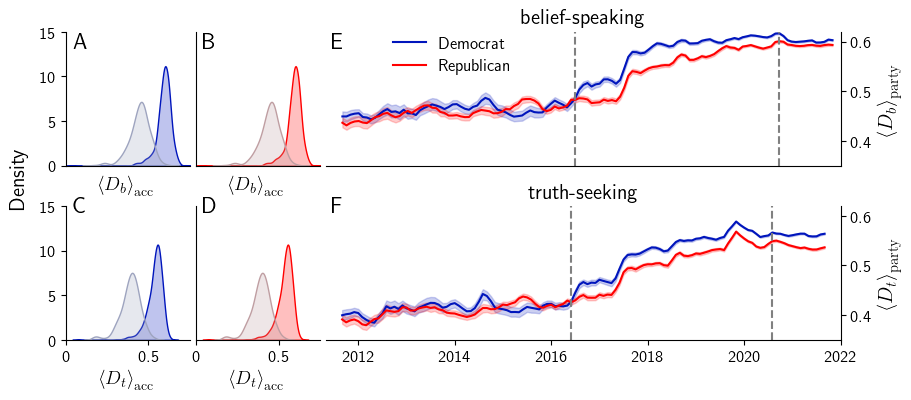

In [16]:
fname = "fig2"
cutoff = 2011
fig = plt.figure(figsize=(10, 4))

gs = GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.05)
ax1 = fig.add_subplot(gs[0, 2:])
ax2 = fig.add_subplot(gs[1, 2:])
ax3 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[0, 1])
ax6 = fig.add_subplot(gs[1, 1])

# timelines
for ax, df, label, title in zip([ax1, ax2], [belief, truth], 
                    ["belief", "truth"], ["belief-speaking", "truth-seeking"]):
    for party, color in zip(["Democrat", "Republican"], [demblue, repred]):
        subset = df[(df["year"] > cutoff) & (df["party"] == party)].copy()
        ax.plot(range(len(subset)), subset[label + "_mean"].rolling(3).mean(),
                color=color, label=party)
        ax.fill_between(range(len(subset)), 
                         subset[label + "_perc_2.5"].rolling(3).mean(),
                         subset[label + "_perc_97.5"].rolling(3).mean(),
                         color=color, alpha=0.2)

    ax.set_ylim(0.35, 0.62)
    ax.set_xlim(-2, 124)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(title, fontsize=15)
    ax.plot([59, 59], [0, 0.2], "--", color="grey")
    ax.plot([107, 107], [0, 0.2], "--", color="grey")
    
    if label == "truth":
        ax.set_xticks([6, 30, 54, 78, 102, 126])
        ax.set_xticklabels(["2012", "2014", "2016", "2018", "2020", "2022"],
                           fontsize=12)
    else:
        ax.set_xticks([])
        ax.legend(loc=2, fontsize=12, bbox_to_anchor=[0.1, 1.08, 0, 0], frameon=False)
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_yticks([0.4, 0.5, 0.6])
    ax.set_yticklabels([0.4, 0.5, 0.6], fontsize=12)
    if label == "belief":
        ax.set_ylabel("$\\left<D_b\\right>_\\mathrm{party}$", fontsize=15)
    else:
        ax.set_ylabel("$\\left<D_t\\right>_\\mathrm{party}$", fontsize=15)

    
# marginal distributions
axes_grid = np.asarray([[ax3, ax5], [ax4, ax6]])
label_dict = {"belief":"belief-speaking", "truth":"truth-seeking"}
palettes = {"Democrat":[demgrey, demblue], "Republican":[repgrey, repred]}

for i, comp in enumerate(["belief", "truth"]):
    label = label_dict[comp]
    axes = axes_grid[i, 0:]
    
    cols = ["party", f"avg_{comp}_score_2010_to_2013", f"avg_{comp}_score_2019_to_2022"]
    subset = users[users["party"].isin(["Democrat", "Republican"])][cols].copy()
    subset = subset.melt(
        id_vars=["party"], 
        var_name="period", 
        value_name=f"avg_{comp}_score"
    )
    subset["period"] = subset["period"].replace({
        f"avg_{comp}_score_2010_to_2013":"2010_to_2013",
        f"avg_{comp}_score_2019_to_2022":"2019_to_2022"
    })
    
    for party, ax, in zip(["Democrat", "Republican"], axes):
        legend = False
        sns.kdeplot(
            ax=ax,
            data=subset,
            x=f"avg_{comp}_score",
            hue="period",
            hue_order=["2010_to_2013", "2019_to_2022"],
            palette=palettes[party],
            fill=True,
            legend=False,
            common_norm=False
        )
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if party == "Republican": 
            ax.set_ylabel("")
            ax.set_yticks([])
        else:
            ax.set_yticks([0, 5, 10, 15])
            ax.set_yticklabels([0, 5, 10, 15], fontsize=12)
            if comp == "belief":
                ax.set_ylabel("Density", fontsize=15)
                ax.yaxis.set_label_coords(-0.3, -0.1)
            else:
                ax.set_ylabel("")
        ax.set_xlim(0, 0.75)
        ax.set_ylim(0, 15)
        
        if comp == "belief":
            ax.set_xticks([])
            ax.set_xlabel("$\\left<D_b\\right>_\\mathrm{acc}$", fontsize=14)
        else:
            ax.set_xticks([0, 0.5])
            ax.set_xticklabels([0, 0.5], fontsize=12)
            ax.set_xlabel("$\\left<D_t\\right>_\\mathrm{acc}$", fontsize=14)
        
                
# election indications
ax1.plot([59, 59], [0.35, 0.62], '--', color="grey")
ax1.plot([109, 109], [0.35, 0.62], '--', color="grey")
ax2.plot([59, 59], [0.35, 0.62], '--', color="grey")
ax2.plot([109, 109], [0.35, 0.62], '--', color="grey")

fig.text(0.132, 0.84, "A", fontsize=16)
fig.text(0.132, 0.43, "C", fontsize=16)
fig.text(0.262, 0.84, "B", fontsize=16)
fig.text(0.262, 0.43, "D", fontsize=16)
fig.text(0.39, 0.84, "E", fontsize=16)
fig.text(0.39, 0.43, "F", fontsize=16)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 3: misinformation scatter & prediction scores

In [29]:
# read tweet data
parties = ["Democrat", "Republican"]
fname = "tweets.csv.gzip"
cols = ["party", "avg_belief_score", "avg_truth_score", "NG_score", "retweeted"]
tweets = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip", 
    usecols=cols
)
# drop retweets
tweets = tweets[tweets["retweeted"] == False] 
tweets = tweets.drop(columns=["retweeted"])
# drop tweets without NewsGuard score or belief-speaking/truth-seeking similarity
tweets = tweets.dropna() 
tweets = tweets[tweets["party"].isin(parties)]
# transform variables to fit transformations in the regression models
tweets["NG_score"] = tweets["NG_score"] / 100
tweets["avg_belief_score"] = tweets["avg_belief_score"] - \
    tweets["avg_belief_score"].mean()
tweets["avg_truth_score"] = tweets["avg_truth_score"] - \
    tweets["avg_truth_score"].mean()

In [30]:
# draw a sample of tweets and apply vertical jitter
tweet_sample = tweets.sample(n=100000, random_state=42).copy()
jitter = np.asarray([np.random.rand() for i in range(len(tweet_sample))])
jitter = jitter / 50
tweet_sample["NG_score"] = tweet_sample["NG_score"] + jitter

In [31]:
# read the predictions of the regression model for tweets
cols = ["NG", "belief", "truth", "ymin", "ymax", "party"]
fname = "LME_predictions_tweets_belief.csv"
tweet_belief_pred = pd.read_csv(join(src, "tweets", fname), usecols=cols)
fname = "LME_predictions_tweets_truth.csv"
tweet_truth_pred = pd.read_csv(join(src, "tweets", fname), usecols=cols)

tweet_belief_pred_dem = tweet_belief_pred[tweet_belief_pred["party"] == "Democrat"]
tweet_belief_pred_rep = tweet_belief_pred[tweet_belief_pred["party"] == "Republican"]
tweet_truth_pred_dem = tweet_truth_pred[tweet_truth_pred["party"] == "Democrat"]
tweet_truth_pred_rep = tweet_truth_pred[tweet_truth_pred["party"] == "Republican"]

In [32]:
src = "../../data/"
fname = "articles.csv.gzip"
articles = pd.read_csv(join(src, "articles", fname), compression="gzip")

In [33]:
# transform variables to fit transformations in the regression models
articles["NG_score"] = articles["NG_score"] / 100
articles["avg_belief_score"] = articles["avg_belief_score"] - articles["avg_belief_score"].mean()
articles["avg_truth_score"] = articles["avg_truth_score"] - articles["avg_truth_score"].mean()

In [38]:
# read the predictions of the regression model for articles
fname = "OLS_predictions_articles.csv"
predictions = pd.read_csv(join(src, "articles", fname))
article_belief_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "belief")]
article_belief_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "belief")]
article_truth_pred_dem = predictions[(predictions["party"] == "Democrat") &\
                              (predictions["honesty_component"] == "truth")]
article_truth_pred_rep = predictions[(predictions["party"] == "Republican") &\
                              (predictions["honesty_component"] == "truth")]

In [39]:
# draw a sample of articles and apply vertical jitter
article_sample = articles.sample(n=100000, random_state=42).copy()
jitter = np.asarray([np.random.rand() for i in range(len(article_sample))])
jitter = jitter / 50
article_sample["NG_score"] = article_sample["NG_score"] + jitter

In [40]:
def plot_prediction(ax, preds, component):
    '''Plots the prediction from regression models and confidence intervals.'''
    parties = ["Democrat", "Republican"]
    colors = [demblue, repred]    
    for pred, color, party in zip(preds, colors, parties):
        ax.plot(pred[component], pred["NG"], color=color, label=party,
                linewidth=3)
        ax.fill_between(pred[component], pred["NG"], pred["ymin"], 
                        alpha=0.2, color=color)
        ax.fill_between(pred[component], pred["NG"], pred["ymax"], 
                        alpha=0.2, color=color)

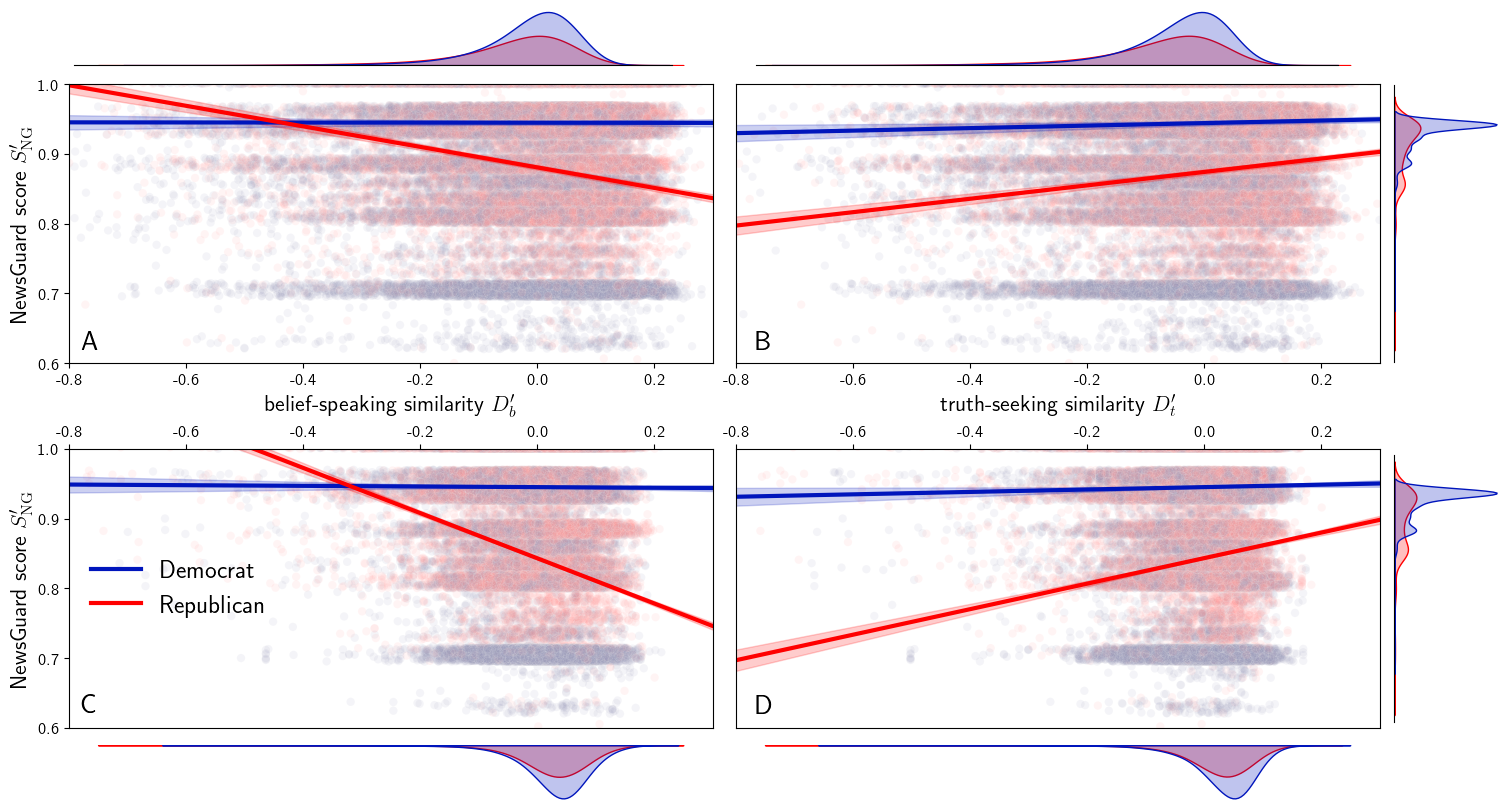

In [41]:
fname = "fig3"

# figure and subplot setup
figsize = (15, 8)
gridspec_kw = dict(
    nrows=4, ncols=3,
    width_ratios=[6, 6, 1],
    height_ratios=[1, 5, 5, 1],
)

fig = plt.figure(figsize=figsize, constrained_layout=True)
axs = fig.add_gridspec(**gridspec_kw).subplots()

axs[0, 2].remove()
axs[3, 2].remove()
axs[3, 0].invert_yaxis()
axs[3, 1].invert_yaxis()

ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
ax5 = axs[1, 2]
ax6 = axs[2, 0]
ax7 = axs[2, 1]
ax8 = axs[2, 2]
ax9 = axs[3, 0]
ax10 = axs[3, 1]

palette1 = [demblue, repred]
palette2 = ["#ff9c9c", "#9c9cbc"]

# marginal distributions of belief-speaking and truth-seeking similarities
for df, comp, ax in zip([tweets] * 2 + [articles] * 2, ["belief", "truth"] * 2,
    [ax1, ax2, ax9, ax10]):
    sns.kdeplot(
        data=df, bw_adjust=3, x=f"avg_{comp}_score", hue="party", alpha=0.25,
        hue_order=parties, palette=palette1, fill=True, ax=ax, legend=False
    )
    
# marginal distributions of NewsGuard scores
for df, ax in zip([tweets, articles], [ax5, ax8]):
    sns.kdeplot(
        data=df, bw_adjust=3, y="NG_score", hue="party", alpha=0.25,
        hue_order=parties, palette=palette1, fill=True, ax=ax, legend=False
    )
    
# scatterplots of individual tweet and article values
for df, comp, ax in zip(
    [tweet_sample, tweet_sample, article_sample, article_sample],
    ["belief", "truth", "belief", "truth"],
    [ax3, ax4, ax6, ax7]):
    sns.scatterplot(
        data=df, x=f"avg_{comp}_score", y="NG_score", hue="party", ax=ax, 
        alpha=0.1, hue_order=parties, palette=palette2, legend=False
    )
    
# predictions from the regression models
plot_prediction(ax3, (tweet_belief_pred_dem, tweet_belief_pred_rep), "belief")
plot_prediction(ax4, (tweet_truth_pred_dem, tweet_truth_pred_rep), "truth")
plot_prediction(ax6, (article_belief_pred_dem, article_belief_pred_rep), "belief")
plot_prediction(ax7, (article_truth_pred_dem, article_truth_pred_rep), "truth")

# axis label and tick cosmetics
sns.despine(ax=axs[0, 0], top=True, right=True, left=True, trim=True)
sns.despine(ax=axs[0, 1], top=True, right=True, left=True, trim=True)
sns.despine(ax=axs[1, 2], top=True, right=True, bottom=True, trim=True)
sns.despine(ax=axs[2, 2], top=True, right=True, bottom=True, trim=True)
sns.despine(ax=axs[3, 0], left=True, right=True, bottom=True, trim=True)
sns.despine(ax=axs[3, 1], left=True, right=True, bottom=True, trim=True)

for ax in [ax1, ax2, ax5, ax8, ax9, ax10]:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    
for ax in [ax4, ax7]:
    ax.set_ylabel("")
    ax.set_yticks([])
    
for ax in [ax3, ax4, ax6, ax7]:
    ax.set_xlim(-0.8, 0.3)
    ax.set_ylim(0.6, 1)
    
for ax in [ax6, ax7]:
    ax.set_xlabel("")
    ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2])
    ax.set_xticklabels([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2], fontsize=12)
    ax.xaxis.tick_top()
    
for ax in [ax3, ax4]:
    ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2])
    ax.set_xticklabels([-0.8, -0.6, -0.4, -0.2, 0.0, 0.2], fontsize=12)

for ax in [ax3, ax6]:
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels([0.6, 0.7, 0.8, 0.9, 1.0], fontsize=12)
    
ax3.set_ylabel("NewsGuard score $S_\\mathrm{NG}'$", fontsize=16)
ax6.set_ylabel("NewsGuard score $S_\\mathrm{NG}'$", fontsize=16)
ax3.set_xlabel("belief-speaking similarity $D_b'$", fontsize=16)
ax4.set_xlabel("truth-seeking similarity $D_t'$", fontsize=16)

ax6.legend(frameon=False, loc=6, fontsize=18)
fig.text(0.05, 0.57, "A", fontsize=20)
fig.text(0.50, 0.57, "B", fontsize=20)
fig.text(0.05, 0.115, "C", fontsize=20)
fig.text(0.50, 0.115, "D", fontsize=20)

plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white", dpi=150)
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

# Extended data

## Fig 1: Three-way interaction

In [42]:
fname = "LME_predictions_tweets_threeway.csv"
preds = pd.read_csv(join(src, "tweets", fname))

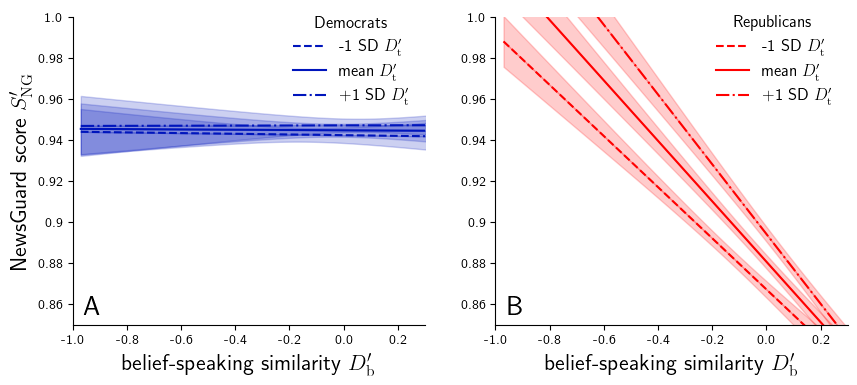

In [43]:
fname = "ext_fig1"
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
alpha = 0.2
for mod, linestyle, label in zip(preds["mod2_group"].unique(), ["--", "-", "-."],
        ["-1 SD $D_\\mathrm{t}'$", "mean $D_\\mathrm{t}'$", "+1 SD $D_\\mathrm{t}'$"]):
    for ax, party, color in zip(axes, ["Democrat", "Republican"], [demblue, repred]):
        subset = preds[(preds["mod2_group"] == mod) & (preds["party"] == party)]
        ax.plot(subset["belief"], subset["NG"], linestyle, color=color,
                label=label)
        ax.fill_between(subset["belief"], subset["NG"], subset["ymax"],
                        color=color, alpha=alpha)
        ax.fill_between(subset["belief"], subset["NG"], subset["ymin"],
                        color=color, alpha=alpha)
yticks = [0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
xticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2]
for ax, party in zip(axes, ["Democrats", "Republicans"]):
    ax.set_ylim(0.85, 1.0)
    ax.set_xlim(-1.0, 0.3)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.set_xlabel("belief-speaking similarity $D_\\mathrm{b}'$", fontsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    legend = ax.legend(loc=1, frameon=False, fontsize=12, title=party,
                       bbox_to_anchor=[1, 1.05, 0, 0])
    plt.setp(legend.get_title(),fontsize=12)
    
axes[0].set_ylabel("NewsGuard score $S_\\mathrm{NG}'$", fontsize=16)
fig.text(0.135, 0.135, "A", fontsize=20)
fig.text(0.56, 0.135, "B", fontsize=20)
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 2: Dictionary robustness

In [13]:
fname = "LME_results_dictionary_robustness.csv"
regression_results = pd.read_csv(join(src, "tweets", fname))

In [5]:
fname = "tweets.csv.gzip"
cols = [
    "retweeted", # used to filter out retweets
    "author_id", # data grouping: independent random variable
    "party", # characteristic of author: independent fixed variable
    "NG_score" # dependent variable
]
# fixed variables from different embeddings and dictionary versions
fixed_variables = [f"avg_truth_score_{i}" for i in range(100)] + \
                  [f"avg_belief_score_{i}" for i in range(100)] + \
                  ["avg_truth_score", "avg_belief_score"]
cols += fixed_variables

tweets = pd.read_csv(
    join(src, "tweets", fname), 
    dtype={"author_id":str},
    compression="gzip",
    usecols=cols,
)

In [6]:
fixed_variables_name_map = \
    {f"avg_truth_score_{i}":f"truth_{i}" for i in range(100)}
for i in range(100):
    fixed_variables_name_map[f"avg_belief_score_{i}"] = f"belief_{i}"

fixed_variables_name_map["avg_truth_score"] = "truth"
fixed_variables_name_map["avg_belief_score"] = "belief"

tweets = tweets.rename(columns=fixed_variables_name_map)

In [7]:
tweets = tweets[tweets["retweeted"] == False] # remove retweets
tweets = tweets.drop(columns=["retweeted"])
tweets = tweets[tweets["party"].isin(["Democrat", "Republican"])] # remove independents
tweets = tweets.dropna() # remove tweets without NG, belief or truth score

In [8]:
tweet_counts = tweets["author_id"]\
    .value_counts()\
    .reset_index()\
    .rename(columns={"index":"author_id", "author_id":"count"})

In [9]:
# filter out authors with only a single tweet
tweets = tweets[tweets["author_id"].isin(tweet_counts[tweet_counts["count"] > 1]["author_id"])]

In [10]:
tweets["NG"] = tweets["NG_score"] / 100
for col in fixed_variables_name_map.values():
    tweets[col] = tweets[col] - tweets[col].mean()
tweets = tweets.copy()

In [11]:
md = smf.mixedlm(
    "NG ~ 1 + belief * truth + belief * truth * party",
    tweets, 
    groups=tweets["author_id"],
    re_formula="~belief * truth"
)
res_glove = md.fit(method=["lbfgs"], maxiter=30000)

/home/jana/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


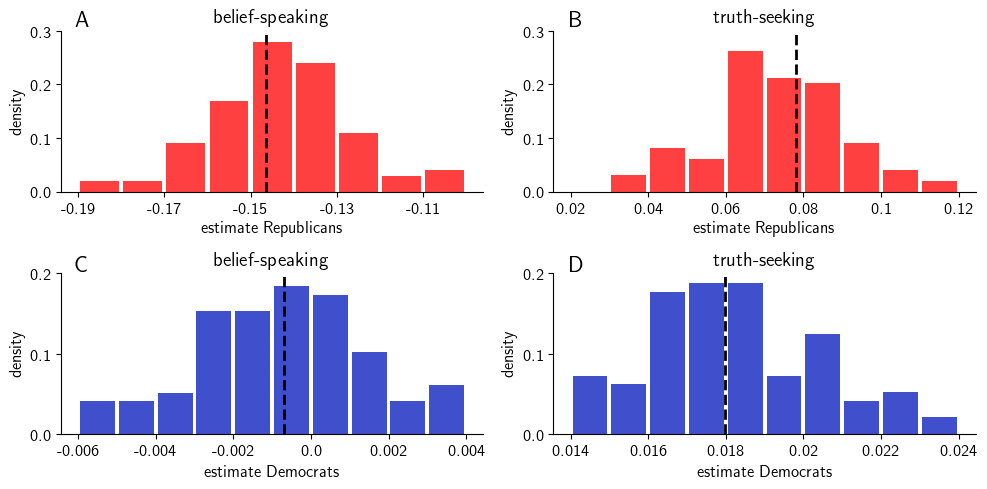

In [15]:
dst = "../../plots"
fname = "ext_fig2"

bins1 = [-0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11, -0.10]
bins2 = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12]
bins3 = [-0.006, -0.005, -0.004, -0.003, -0.002, -0.001, 0.00, 0.001, 0.002, 0.003, 0.004]
bins4 = [0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.020, 0.021, 0.022, 0.023, 0.024]
yticks1 = [0.0, 0.1, 0.2, 0.3]
yticks2 = [0.0, 0.1, 0.2]

fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for ax_row, col, ymax, color, party, bin_collection, yticks in zip(
    [axes[0, 0:], axes[1, 0:]],
    ["{}:party[T.Republican]_estimate", "{}_estimate"],
    [0.3, 0.2], [repred, demblue], ["Republicans", "Democrats"],
    [[bins1, bins2], [bins3, bins4]],
    [yticks1, yticks2]
):
    for ax, comp, bins, title in zip(ax_row, ["belief", "truth"], 
        bin_collection, ["belief-speaking", "truth-seeking"]
    ):
        sns.histplot(
            ax=ax,
            data=regression_results, 
            x=col.format(comp),
            stat="probability", 
            color=color,
            edgecolor=None,
            shrink=0.9,
            bins=np.asarray(bins)
        )
        ax.set_ylabel("density", fontsize=12)
        ax.set_xlabel(f"estimate {party}", fontsize=12)
        
        param = col.format(comp).replace("_estimate", "")
        estimate = res_glove.params[param]
        ax.plot(
            [estimate, estimate], 
            [0, ymax - ymax * 0.01],
            '--',
            color="k",
            linewidth=2,
            label="full dictionary"
            )
        ax.set_ylim(0, ymax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title(title, fontsize=14)
        ax.set_xticks(bins[::2])
        ax.set_xticklabels(bins[::2], fontsize=12)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks, fontsize=12)

fig.text(0.08, 0.935, "A", fontsize=16)
fig.text(0.575, 0.935, "B", fontsize=16)
fig.text(0.08, 0.445, "C", fontsize=16)
fig.text(0.575, 0.445, "D", fontsize=16)
fig.tight_layout()
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 3: coverage

In [45]:
fname = "NG_coverage.csv"
coverage = pd.read_csv(join(src, "bootstrapping", fname))

In [46]:
coverage = coverage[["year", "month", "NG_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
coverage = coverage.reset_index()
coverage.columns = ["year", "month", "party", "NG_coverage_mean", "NG_coverage_std"]

In [47]:
fname = "independent_coverage.csv"
independent_coverage = pd.read_csv(join(src, "bootstrapping", fname))

In [48]:
independent_coverage = independent_coverage\
    [["year", "month", "independent_coverage", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", "std"])
independent_coverage = independent_coverage.reset_index()
independent_coverage.columns = ["year", "month", "party", 
                    "independent_coverage_mean", "independent_coverage_std"]

In [49]:
def plot_coverage(ax, data, ycol, cutoff=2011):
    parties = ["Democrat", "Republican"]
    for party, color in zip(parties, [demblue, repred]):
        df = data[(data["year"] > cutoff) & (data["party"] == party)]
        ax.plot(range(len(df)), df[ycol + "_mean"], color=color, label=party)
        ax.fill_between(range(len(df)), 
                         df[ycol + "_mean"],
                         df[ycol + "_mean"] + df[ycol + "_std"],
                         color=color, alpha=0.2)
        ax.fill_between(range(len(df)), 
                         df[ycol + "_mean"],
                         df[ycol + "_mean"] - df[ycol + "_std"],
                         color=color, alpha=0.2)
        ax.set_ylim(0, 0.68)
        ax.set_yticks([0, 0.2, 0.4, 0.6])
        ax.set_yticklabels(["0%", "20%", "40%", "60%"], fontsize=12)

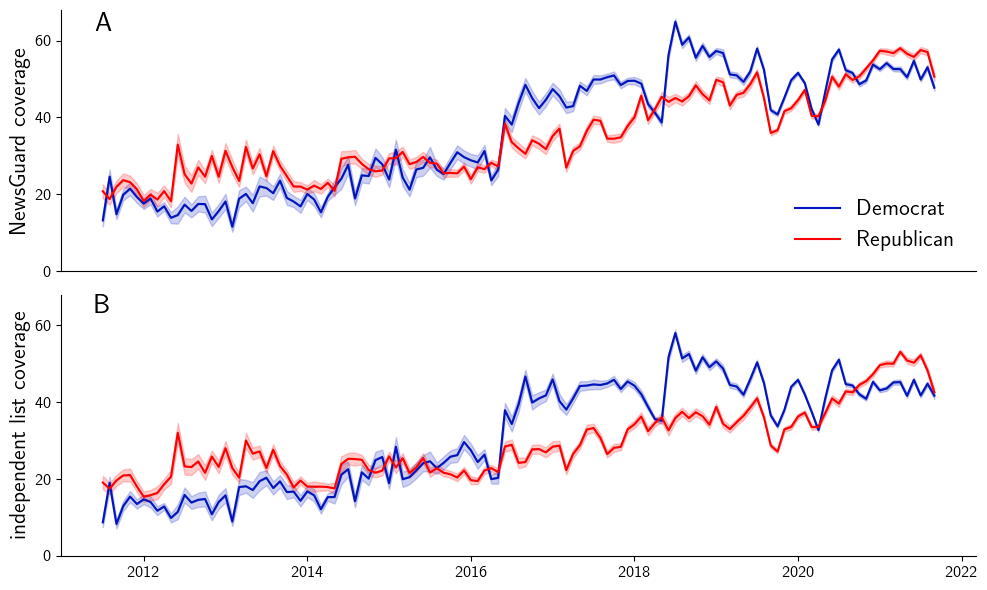

In [50]:
fname = "ext_fig3"
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_coverage(axes[0], coverage, "NG_coverage")
plot_coverage(axes[1], independent_coverage, "independent_coverage")

axes[0].set_xticks([])
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axes[1].set_xticks(range(6, 131, 24))
axes[1].set_xticklabels(range(2012, 2023, 2), fontsize=12)
axes[0].legend(loc=4, fontsize=16, frameon=False)
axes[0].set_ylabel("NewsGuard coverage", fontsize=16)
axes[1].set_ylabel("independent list coverage", fontsize=16)
fig.tight_layout()
fig.text(0.1, 0.94, "A", fontsize=20)
fig.text(0.1, 0.47, "B", fontsize=20)
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 4: full scatterplots

In [66]:
# read tweet data
parties = ["Democrat", "Republican"]
fname = "tweets.csv.gzip"
cols = ["party", "avg_belief_score", "avg_truth_score", "NG_score", "retweeted"]
tweets = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip", 
    usecols=cols
)
# drop retweets
tweets = tweets[tweets["retweeted"] == False] 
tweets = tweets.drop(columns=["retweeted"])
# drop tweets without NewsGuard score or belief-speaking/truth-seeking similarity
tweets = tweets.dropna() 
tweets = tweets[tweets["party"].isin(parties)]
# transform variables to fit transformations in the regression models
tweets["NG_score"] = tweets["NG_score"] / 100
tweets["avg_belief_score"] = tweets["avg_belief_score"] - \
    tweets["avg_belief_score"].mean()
tweets["avg_truth_score"] = tweets["avg_truth_score"] - \
    tweets["avg_truth_score"].mean()
# apply vertical jitter
jitter = np.asarray([np.random.rand() for i in range(len(tweets))])
jitter = jitter / 50
tweets["NG_score"] = tweets["NG_score"] + jitter

In [67]:
fname = "articles.csv.gzip"
article_honesty_scores = pd.read_csv(
    join(src, "articles", fname),
    compression="gzip"
)

# transform variables to fit transformations in the regression models
articles["NG_score"] = articles["NG_score"] / 100
articles["avg_belief_score"] = articles["avg_belief_score"] - articles["avg_belief_score"].mean()
articles["avg_truth_score"] = articles["avg_truth_score"] - articles["avg_truth_score"].mean()
# apply vertical jitter
jitter = np.asarray([np.random.rand() for i in range(len(articles))])
jitter = jitter / 50
articles["NG_score"] = articles["NG_score"] + jitter

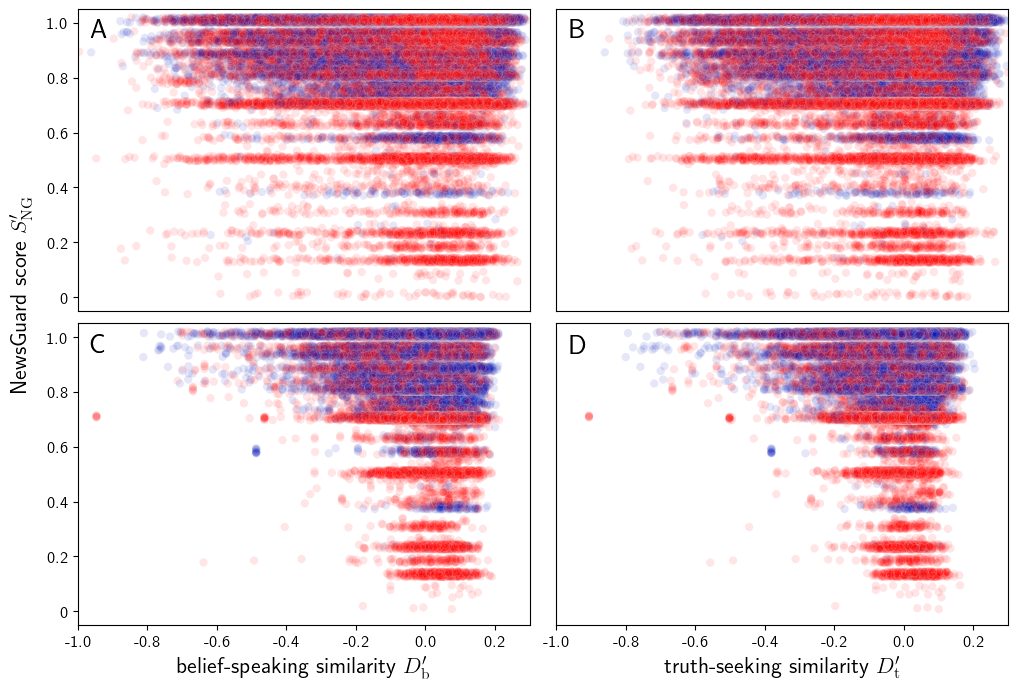

In [68]:
fname = "ext_fig4"
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 18, figure=fig, hspace=0.04, wspace=1)
ax0 = fig.add_subplot(gs[0, 0:9])
ax1 = fig.add_subplot(gs[0, 9:])
ax2 = fig.add_subplot(gs[1, 0:9])
ax3 = fig.add_subplot(gs[1, 9:])

parties = ["Democrat", "Republican"]
yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2]

axes = [ax0, ax1, ax2, ax3]
for df, comp, ax in zip(
    [tweets, tweets, articles, articles],
    ["belief", "truth", "belief", "truth"],
    axes):
    sns.scatterplot(
        data=df, x=f"avg_{comp}_score", y="NG_score", hue="party", ax=ax, 
        alpha=0.1, hue_order=parties, palette=[demblue, repred], legend=False
    )
    ax.set_xlim(-1.0, 0.3)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
for ax in [ax1, ax3]:
    ax.set_yticks([])
for ax in [ax0, ax1]:
    ax.set_xticks([])
for ax in [ax2, ax3]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=12)
for ax in [ax0, ax2]:
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=12)

ax2.set_ylabel("NewsGuard score $S_\mathrm{NG}'$", fontsize=16)
ax2.yaxis.set_label_coords(-0.1, 1.1)
ax2.set_xlabel("belief-speaking similarity $D_\\mathrm{b}'$", fontsize=16)
ax3.set_xlabel("truth-seeking similarity $D_\\mathrm{t}'$", fontsize=16)

fig.text(0.135, 0.845, "A", fontsize=20)
fig.text(0.535, 0.845, "B", fontsize=20)
fig.text(0.135, 0.45, "C", fontsize=20)
fig.text(0.535, 0.45, "D", fontsize=20)
    
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white", dpi=150)
#plt.savefig(join(dst, fname + ".pdf"),bbox_inches="tight", facecolor="white")

# Supplementary Information

## Fig 3: Positive and negative emotion LIWC score timelines

In [54]:
fname = "LIWC.csv"
LIWC_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))
fname = "LIWC_belief.csv"
LIWC_belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))
fname = "LIWC_truth.csv"
LIWC_truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))
fname = "LIWC_neutral_belief.csv"
LIWC_neutral_belief_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))
fname = "LIWC_neutral_truth.csv"
LIWC_neutral_truth_bootstrap = pd.read_csv(join(src, "bootstrapping", fname))

In [55]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [56]:
cols = ["LIWC_analytic_share", "LIWC_authentic_share", "LIWC_moral_share",
        "LIWC_emo_pos_share", "LIWC_emo_neg_share"]
LIWC = LIWC_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_belief = LIWC_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_truth = LIWC_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral_belief = LIWC_neutral_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral_truth = LIWC_neutral_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()

In [57]:
def plot_component(ax, component, component_title, baseline, col, ylim, 
                     window=3, years=False, yticks=[0, 1, 2, 3, 4]):
    dem = component[component["party"] == "Democrat"].copy()
    rep = component[component["party"] == "Republican"].copy()
    
    dem_bl = baseline[baseline["party"] == "Democrat"]
    rep_bl = baseline[baseline["party"] == "Republican"]
    

    dem_avg = dem[col]["mean"].rolling(window).mean().values /\
        dem_bl[col]["mean"].rolling(window).mean().values
    dem_lo = dem[col]["percentile_2.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_2.5"].rolling(window).mean().values
    dem_hi = dem[col]["percentile_97.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_97.5"].rolling(window).mean().values
    rep_avg = rep[col]["mean"].rolling(window).mean().values /\
        rep_bl[col]["mean"].rolling(window).mean().values
    rep_lo = rep[col]["percentile_2.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_2.5"].rolling(window).mean().values
    rep_hi = rep[col]["percentile_97.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_97.5"].rolling(window).mean().values
    
    ax.plot(range(len(dem)), dem_avg, color=demblue)
    ax.fill_between(range(len(dem)), dem_lo, dem_hi,
                    color=demblue, alpha=alpha)
    
    ax.plot(range(len(rep)), rep_avg, color=repred)
    ax.fill_between(range(len(rep)), rep_lo, rep_hi,
                    color=repred, alpha=alpha)
        
    if years:
        ax.set_xticks(list(range(3, 12*12 + 1, 12)))
        ax.set_xticklabels(range(2011, 2023), fontsize=16)
    else:
        ax.set_xticks([])
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=16)
    ax.set_xlim(-1, len(dem) + 5)
    ax.set_ylim(ylim[0], ylim[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_title(component_title, fontsize=24)
    
    # add election dates
    ax.plot([74, 74], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color = "k")
    ax.plot([122, 122], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', color = "k")
    
    # indicate baseline
    ax.plot([-1, len(dem) -1 ], [1, 1], '--', color="k")

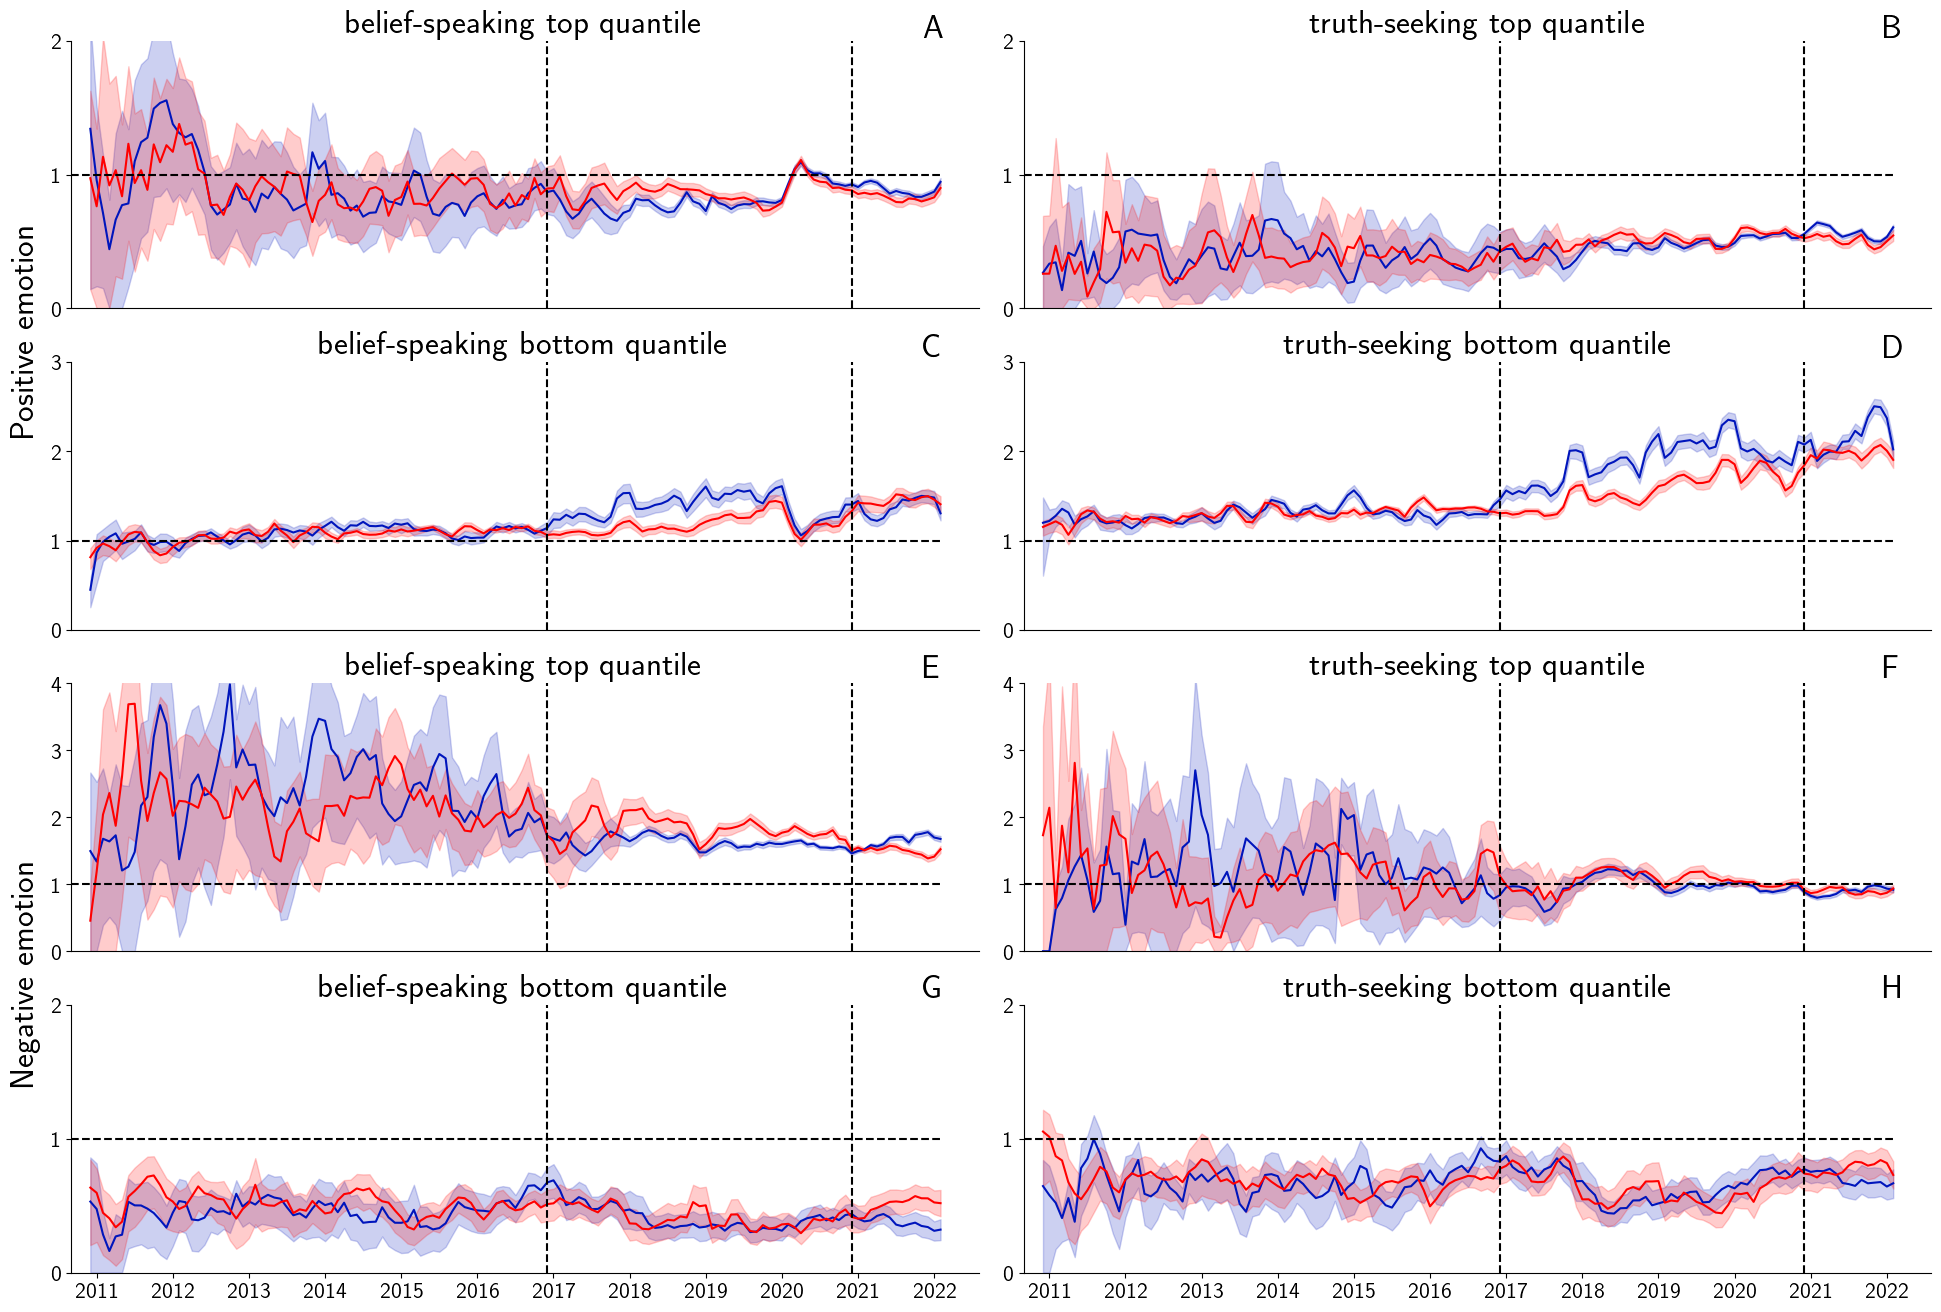

In [58]:
fname = "SI_fig3"
alpha = 0.2

fig = plt.figure(figsize=(24, 16))

gs = GridSpec(8, 2, figure=fig, hspace=0.5, wspace=0.05)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1])
ax3 = fig.add_subplot(gs[4:6, 0])
ax4 = fig.add_subplot(gs[4:6, 1])

ax5 = fig.add_subplot(gs[2:4, 0])
ax6 = fig.add_subplot(gs[2:4, 1])
ax7 = fig.add_subplot(gs[6:8, 0])
ax8 = fig.add_subplot(gs[6:8, 1])

 
data = {
    "belief-speaking":LIWC_belief,
    "truth-seeking":LIWC_truth,
    "neutral_belief":LIWC_neutral_belief,
    "neutral_truth":LIWC_neutral_truth,
    "baseline":LIWC
}

ylims = {
    "LIWC_emo_pos_share":[0, 4],
    "LIWC_emo_neg_share":[0, 4],
}

plot_component(ax1, data["belief-speaking"], "belief-speaking top quantile", data["baseline"],
               "LIWC_emo_pos_share", [0, 2], window=3)
plot_component(ax2, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
               "LIWC_emo_pos_share", [0, 2], window=3)
plot_component(ax3, data["belief-speaking"], "belief-speaking top quantile", data["baseline"],
               "LIWC_emo_neg_share", ylims["LIWC_emo_neg_share"], window=3,
               yticks=[0, 1, 2, 3, 4])
plot_component(ax4, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
               "LIWC_emo_neg_share", ylims["LIWC_emo_neg_share"], window=3,
               yticks=[0, 1, 2, 3, 4])

plot_component(ax5, data["neutral_belief"], "belief-speaking bottom quantile", data["baseline"],
               "LIWC_emo_pos_share", [0, 3], window=3)
plot_component(ax6, data["neutral_truth"], "truth-seeking bottom quantile", data["baseline"],
               "LIWC_emo_pos_share", [0, 3], window=3)
plot_component(ax7, data["neutral_belief"], "belief-speaking bottom quantile", data["baseline"],
               "LIWC_emo_neg_share", [0, 2], window=3, years=True)
plot_component(ax8, data["neutral_truth"], "truth-seeking bottom quantile", data["baseline"],
               "LIWC_emo_neg_share", [0, 2], window=3, years=True)

ax1.set_ylabel("Positive emotion", fontsize=24)
ax1.yaxis.set_label_coords(-0.035, -0.08)
ax3.set_ylabel("Negative emotion", fontsize=24)
ax3.yaxis.set_label_coords(-0.035, -0.08)

fig.text(0.48, 0.882, "A", fontsize=24)
fig.text(0.88, 0.882, "B", fontsize=24)
fig.text(0.48, 0.682, "C", fontsize=24)
fig.text(0.88, 0.682, "D", fontsize=24)
fig.text(0.48, 0.482, "E", fontsize=24)
fig.text(0.88, 0.482, "F", fontsize=24)
fig.text(0.48, 0.282, "G", fontsize=24)
fig.text(0.88, 0.282, "H", fontsize=24)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 4: Analytic, authentic and moral LIWC score timelines

In [33]:
src = "../../data/bootstrapping"

In [59]:
fname = "LIWC"
LIWC_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_belief"
LIWC_belief_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_truth"
LIWC_truth_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_neutral_belief"
LIWC_neutral_belief_bootstrap = pd.read_csv(join(src, fname + ".csv"))
fname = "LIWC_neutral_truth"
LIWC_neutral_truth_bootstrap = pd.read_csv(join(src, fname + ".csv"))

In [60]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [61]:
cols = ["LIWC_analytic_share", "LIWC_authentic_share", "LIWC_moral_share",
        "LIWC_emo_pos_share", "LIWC_emo_neg_share"]
LIWC = LIWC_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_belief = LIWC_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_truth = LIWC_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral_belief = LIWC_neutral_belief_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()
LIWC_neutral_truth = LIWC_neutral_truth_bootstrap[cols + ["year", "month", "party"]]\
    .groupby(["year", "month", "party"])\
    .agg(["mean", percentile(2.5), percentile(97.5)])\
    .reset_index()

In [62]:
def plot_component(ax, component, component_title, baseline, col, ylim, 
                     window=3, years=False, yticks=[0.5, 1, 1.5]):
    dem = component[component["party"] == "Democrat"].copy()
    rep = component[component["party"] == "Republican"].copy()
    
    dem_bl = baseline[baseline["party"] == "Democrat"]
    rep_bl = baseline[baseline["party"] == "Republican"]
    

    dem_avg = dem[col]["mean"].rolling(window).mean().values /\
        dem_bl[col]["mean"].rolling(window).mean().values
    dem_lo = dem[col]["percentile_2.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_2.5"].rolling(window).mean().values
    dem_hi = dem[col]["percentile_97.5"].rolling(window).mean().values /\
        dem_bl[col]["percentile_97.5"].rolling(window).mean().values
    rep_avg = rep[col]["mean"].rolling(window).mean().values /\
        rep_bl[col]["mean"].rolling(window).mean().values
    rep_lo = rep[col]["percentile_2.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_2.5"].rolling(window).mean().values
    rep_hi = rep[col]["percentile_97.5"].rolling(window).mean().values /\
        rep_bl[col]["percentile_97.5"].rolling(window).mean().values
    
    ax.plot(range(len(dem)), dem_avg, color=demblue)
    ax.fill_between(range(len(dem)), dem_lo, dem_hi,
                    color=demblue, alpha=alpha)
    
    ax.plot(range(len(rep)), rep_avg, color=repred)
    ax.fill_between(range(len(rep)), rep_lo, rep_hi,
                    color=repred, alpha=alpha)
        
    if years:
        ax.set_xticks(list(range(3, 12*12 + 1, 12)))
        ax.set_xticklabels(range(2011, 2023), fontsize=16)
    else:
        ax.set_xticks([])
        
    ax.set_title(component_title, fontsize=24, y=1, pad=-8)
        
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=16)
    ax.set_xlim(-1, len(dem) + 5)
    ax.set_ylim(ylim[0], ylim[1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # add election dates
    ax.plot([74, 74], [ax.get_ylim()[0], ax.get_ylim()[1]*0.9], '--', color = "k")
    ax.plot([122, 122], [ax.get_ylim()[0], ax.get_ylim()[1]*0.9], '--', color = "k")
    
    # indicate baseline
    ax.plot([-1, len(dem) -1 ], [1, 1], '--', color="k")

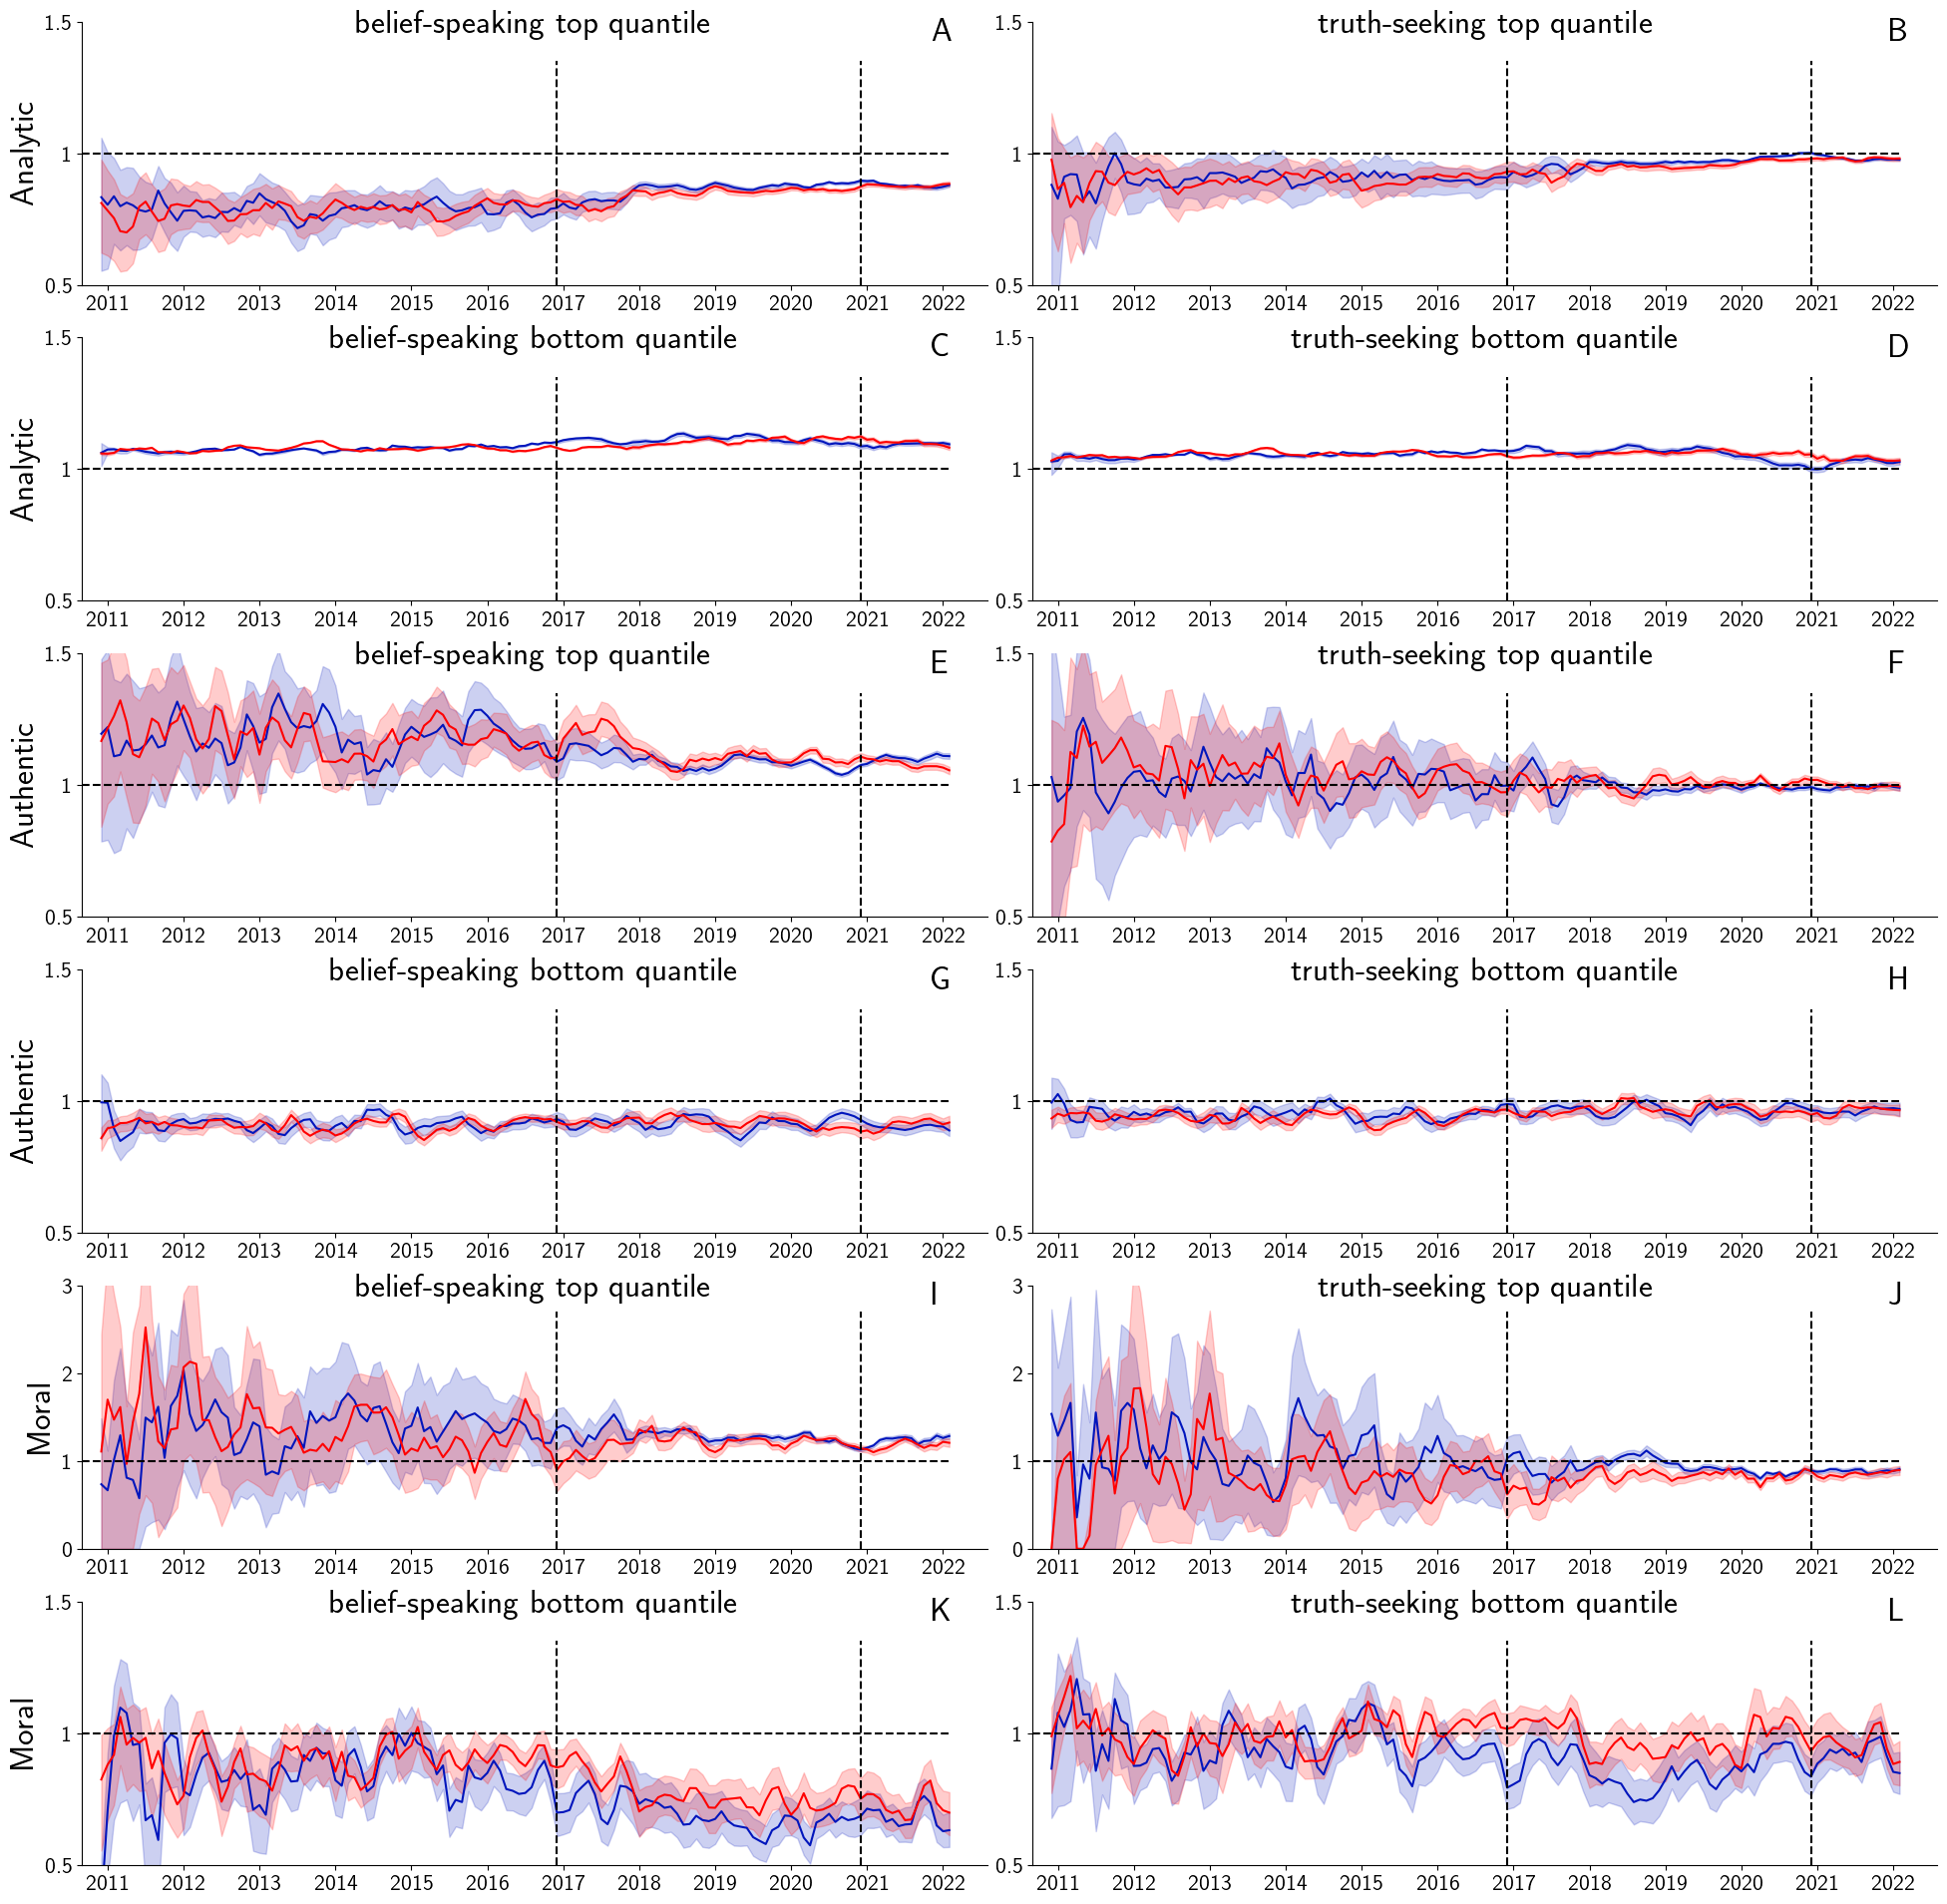

In [63]:
fname = "SI_fig4"
alpha = 0.2

fig = plt.figure(figsize=(24, 24))

gs = GridSpec(12, 2, figure=fig, hspace=0.5, wspace=0.05)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1])
ax3 = fig.add_subplot(gs[2:4, 0])
ax4 = fig.add_subplot(gs[2:4, 1])

ax5 = fig.add_subplot(gs[4:6, 0])
ax6 = fig.add_subplot(gs[4:6, 1])
ax7 = fig.add_subplot(gs[6:8, 0])
ax8 = fig.add_subplot(gs[6:8, 1])

ax9 = fig.add_subplot(gs[8:10, 0])
ax10 = fig.add_subplot(gs[8:10, 1])
ax11 = fig.add_subplot(gs[10:, 0])
ax12 = fig.add_subplot(gs[10:, 1])

 
data = {
    "belief-speaking":LIWC_belief,
    "truth-seeking":LIWC_truth,
    "neutral_belief":LIWC_neutral_belief,
    "neutral_truth":LIWC_neutral_truth,
    "baseline":LIWC
}

ylims = {
    "LIWC_analytic_share":[0.5, 1.5],
    "LIWC_authentic_share":[0.5, 1.5],
    "LIWC_moral_share":[0, 3]
}

# analytic
plot_component(
    ax1, data["belief-speaking"], "belief-speaking top quantile", 
    data["baseline"], "LIWC_analytic_share", ylims["LIWC_analytic_share"],
    years=True
    )
plot_component(
    ax2, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
    "LIWC_analytic_share", ylims["LIWC_analytic_share"], years=True
)
plot_component(
    ax3, data["neutral_belief"], "belief-speaking bottom quantile", 
    data["baseline"], "LIWC_analytic_share", ylims["LIWC_analytic_share"],
    years=True
)
plot_component(
    ax4, data["neutral_truth"], "truth-seeking bottom quantile", 
    data["baseline"], "LIWC_analytic_share", ylims["LIWC_analytic_share"],
    years=True
)

# authentic
plot_component(
    ax5, data["belief-speaking"], "belief-speaking top quantile", 
    data["baseline"], "LIWC_authentic_share", ylims["LIWC_authentic_share"],
    years=True
)
plot_component(
    ax6, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
    "LIWC_authentic_share", ylims["LIWC_authentic_share"], years=True
)
plot_component(
    ax7, data["neutral_belief"], "belief-speaking bottom quantile", 
    data["baseline"], "LIWC_authentic_share", ylims["LIWC_authentic_share"],
    years=True
)
plot_component(
    ax8, data["neutral_truth"], "truth-seeking bottom quantile", 
    data["baseline"], "LIWC_authentic_share", ylims["LIWC_authentic_share"],
    years=True
)

# moral
plot_component(
    ax9, data["belief-speaking"], "belief-speaking top quantile", 
    data["baseline"], "LIWC_moral_share", ylims["LIWC_moral_share"],
    yticks=[0, 1, 2, 3], years=True
)
plot_component(
    ax10, data["truth-seeking"], "truth-seeking top quantile", data["baseline"],
    "LIWC_moral_share", ylims["LIWC_moral_share"], yticks=[0, 1, 2, 3],
    years=True
)
plot_component(
    ax11, data["neutral_belief"], "belief-speaking bottom quantile", 
    data["baseline"], "LIWC_moral_share", [0.5, 1.5], years=True
)
plot_component(
    ax12, data["neutral_truth"], "truth-seeking bottom quantile", 
    data["baseline"], "LIWC_moral_share", [0.5, 1.5], years=True
)


ax1.set_ylabel("Analytic", fontsize=24)
ax3.set_ylabel("Analytic", fontsize=24)
ax5.set_ylabel("Authentic", fontsize=24)
ax7.set_ylabel("Authentic", fontsize=24)
ax9.set_ylabel("Moral", fontsize=24)
ax11.set_ylabel("Moral", fontsize=24)

fig.text(0.48, 0.872, "A", fontsize=24)
fig.text(0.88, 0.872, "B", fontsize=24)
fig.text(0.48, 0.740, "C", fontsize=24)
fig.text(0.88, 0.740, "D", fontsize=24)
fig.text(0.48, 0.608, "E", fontsize=24)
fig.text(0.88, 0.608, "F", fontsize=24)
fig.text(0.48, 0.476, "G", fontsize=24)
fig.text(0.88, 0.476, "H", fontsize=24)
fig.text(0.48, 0.344, "I", fontsize=24)
fig.text(0.88, 0.344, "J", fontsize=24)
fig.text(0.48, 0.212, "K", fontsize=24)
fig.text(0.88, 0.212, "L", fontsize=24)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

## Fig 5: Party-topic breakdowns

In [39]:
# load topic labels for all tweets
fname = "topics_all_docs.csv.gzip"
topics = pd.read_csv(
    join(src, "tweets", fname),
    compression="gzip",
    dtype={"id":str}
)

In [40]:
# merge with party information
fname = "US_politician_tweets_2010-11-06_to_2022-03-16.csv.gzip"
tweets = pd.read_csv(
    join(src, "tweets", fname), 
    usecols=["id", "party"],
    compression="gzip",
    dtype={"id":str}
)
topics = pd.merge(
    topics,
    tweets,
    how="left",
    left_on="id",
    right_on="id"
)
# retain only tweets form Republicans and Democrats (no independents)
topics = topics[topics["party"].isin(["Democrat", "Republican"])]
del tweets

In [41]:
# calculate corpus similarity averages
avg_belief = topics["avg_belief"].mean()
avg_truth = topics["avg_truth"].mean()
# calculate within-party corpus similarity averages
avg_belief_dem = topics[topics["party"] == "Democrat"]["avg_belief"].mean()
avg_belief_rep = topics[topics["party"] == "Republican"]["avg_belief"].mean()
avg_truth_dem = topics[topics["party"] == "Democrat"]["avg_truth"].mean()
avg_truth_rep = topics[topics["party"] == "Republican"]["avg_truth"].mean()

In [42]:
# retain only the topics of interest
chosen_topics = [4, 3, 26, 7, 12, 64, 15, 33, 31, 19, 10, 21, 37, 0, 35,
                 17, 143, 149, 225, 293]
topics = topics[topics["topic"].isin(chosen_topics)]

In [43]:
# merge with topic names
fname = "topics_per_class_ddr.csv"
topic_names = pd.read_csv(join(src, "tweets", fname))\
    .rename(columns={"Topic":"topic", "Name":"name"})
topics = pd.merge(
    topics,
    topic_names[["topic", "name"]].drop_duplicates(),
    how="left",
    left_on="topic",
    right_on="topic"
)
del topic_names

In [44]:
# beautify the topic name strings
topics["name"] = topics["name"].apply(lambda x: x.split("_"))
topics["name"] = topics["name"].apply(lambda x: " $\\vert$ ".join(x[1:]))

In [45]:
# calculate similarity differences
topics["avg_belief_norm"] = topics["avg_belief"] - avg_belief
topics["avg_truth_norm"] = topics["avg_truth"] - avg_truth

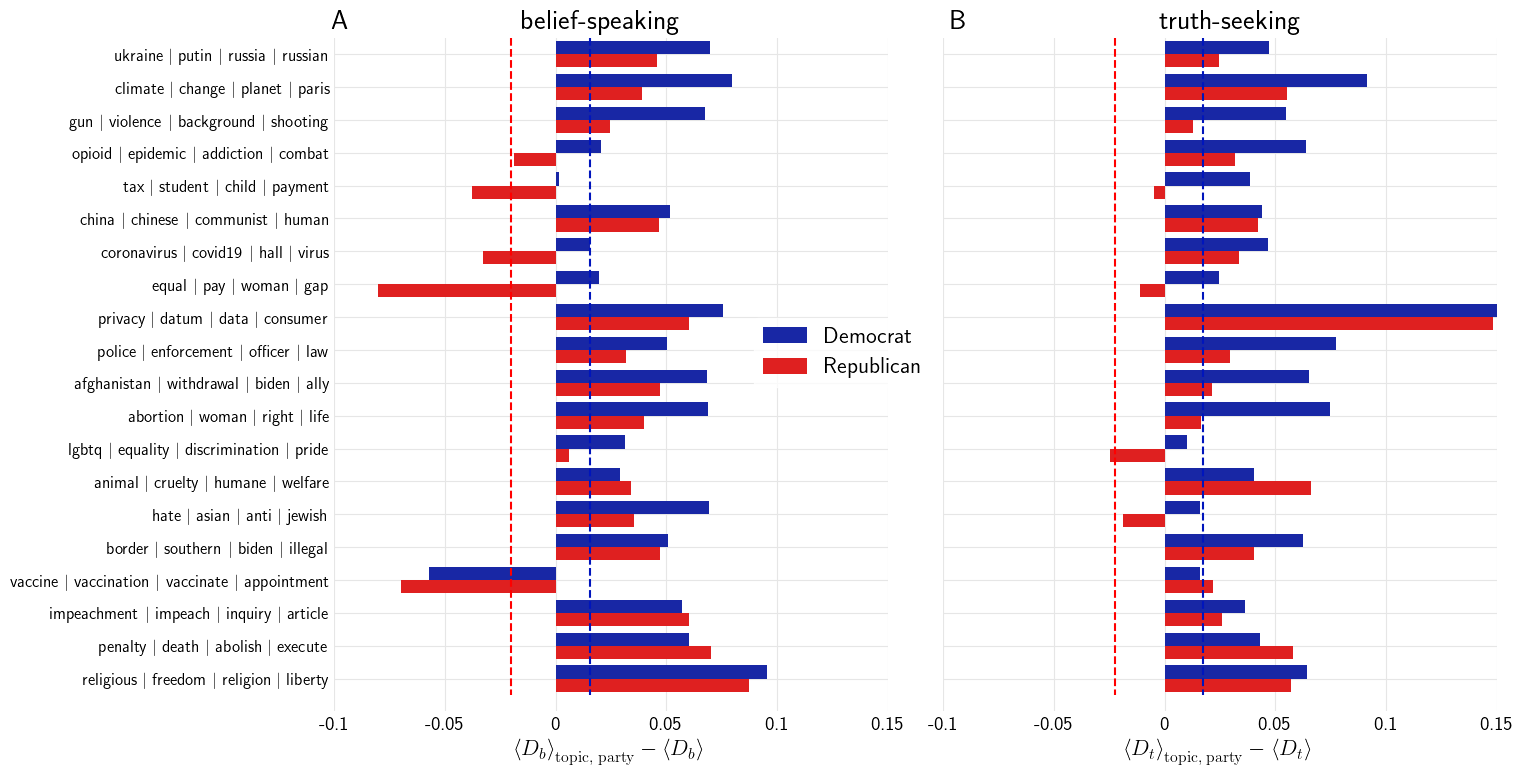

In [46]:
# set up figure and subplots
fname = "SI_fig5"
fig = plt.figure(figsize=(15, 8.75))
gs = GridSpec(7, 2, figure=fig, hspace=0.8, wspace=0.1)
ax1 = fig.add_subplot(gs[0:, 0])
ax2 = fig.add_subplot(gs[0:, 1])
axes = [ax1, ax2]

# belief-speaking
sns.barplot(x="avg_belief_norm", 
            y="name",
            hue="party",
            data=topics,
            ax=axes[0],
            palette=[demblue, repred], 
            hue_order=["Democrat", "Republican"],
            zorder=3,
            ci=None)
# truth-seeking
sns.barplot(x="avg_truth_norm", 
            y="name",
            hue="party",
            data=topics,
            ax=axes[1],
            palette=[demblue, repred], 
            hue_order=["Democrat", "Republican"],
            zorder=3,
            ci=None)

# axis labels, ticks, annotations and grids
ax1.tick_params(axis='y', labelsize=12)

ax2.set_xlabel("")
ax2.legend_.remove()
ax1.set_xlabel("$\\left<D_b\\right>_\\mathrm{topic,\;party} - \\left<D_b\\right>$", fontsize=16)
ax2.set_xlabel("$\\left<D_t\\right>_\\mathrm{topic,\;party} - \\left<D_t\\right>$", fontsize=16)

legend = ax1.legend(loc=1, bbox_to_anchor=[1.1, 0.6, 0, 0], fontsize=16)
legend.get_frame().set_facecolor((1, 1, 1, 1))
legend.get_frame().set_edgecolor((1, 1, 1, 1))

 
ax1.set_xlim(-0.1, 0.15)
ax1.set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax1.set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=14)
ax2.set_xlim(-0.1, 0.15)
ax2.set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15])
ax2.set_xticklabels([-0.1, -0.05, 0, 0.05, 0.1, 0.15], fontsize=14)

ax2.set_yticklabels([])

# mean corpus lines
ax1.plot([avg_belief_dem - avg_belief, avg_belief_dem - avg_belief], [-0.5, len(chosen_topics) - 0.5],
         '--', color=demblue, zorder=4)
ax1.plot([avg_belief_rep - avg_belief, avg_belief_rep - avg_belief], [-0.5, len(chosen_topics) - 0.5],
         '--', color=repred, zorder=4)
ax2.plot([avg_truth_dem - avg_truth, avg_truth_dem - avg_truth], [-0.5, len(chosen_topics) - 0.5],
         '--', color=demblue, zorder=4)
ax2.plot([avg_truth_rep - avg_truth, avg_truth_rep - avg_truth], [-0.5, len(chosen_topics) - 0.5],
         '--', color=repred, zorder=4)
    
for ax in axes:
    ax.set_ylabel("")
    ax.set_ylim(len(chosen_topics), -0.5)
    ax.grid(which="both", zorder=1, color=(230/255, 230/255, 230/255))
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
fig.text(0.123, 0.89, "A", fontsize=20)
fig.text(0.25, 0.89, "belief-speaking", fontsize=20)
fig.text(0.536, 0.89, "B", fontsize=20)
fig.text(0.675, 0.89, "truth-seeking", fontsize=20)

plt.savefig(join(dst, fname + ".pdf"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"), bbox_inches="tight", facecolor="white")

# Additional plots

## Correlation between trustworthiness indicators

In [23]:
src = "../../data"
fname = "US_politician_accounts_2010-11-06_to_2022-03-16.csv"
users = pd.read_csv(join(src, "users", fname))

In [24]:
src = "../../data/bootstrapping"
fname = "user_reliability_score_correlations.csv"
pf_bootstrap = pd.read_csv(join(src, fname))

In [25]:
print("correlation NewsGuard Score with NewsGuard share: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_NGShare"].mean(),
        pf_bootstrap["corr_NGScore_NGShare"].quantile(0.025),
        pf_bootstrap["corr_NGScore_NGShare"].quantile(0.975),))

print("correlation NewsGuard Share with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGShare_pf"].mean(),
        pf_bootstrap["corr_NGShare_pf"].quantile(0.025),
        pf_bootstrap["corr_NGShare_pf"].quantile(0.975),))

print("correlation NewsGuard Share with independent list: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGShare_ind"].mean(),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.025),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.975),))

print("correlation NewsGuard Score with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_pf"].mean(),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.025),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.975),))

print("correlation independent list with politifact: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_ind_pf"].mean(),
        pf_bootstrap["corr_ind_pf"].quantile(0.025),
        pf_bootstrap["corr_ind_pf"].quantile(0.975),))

print("correlation NewsGuard Score with independent list: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_ind"].mean(),
        pf_bootstrap["corr_NGScore_ind"].quantile(0.025),
        pf_bootstrap["corr_NGScore_ind"].quantile(0.975),))

print("correlation NewsGuard Score with accuracy score: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_accuracy"].mean(),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.025),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.975),))

print("correlation NewsGuard Score with transparency score: {:1.4f} [{:1.4f}; {:1.4f}]".format(\
        pf_bootstrap["corr_NGScore_transparency"].mean(),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.025),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.975),))

correlation NewsGuard Score with NewsGuard share: 0.7538 [0.7093; 0.7941]
correlation NewsGuard Share with politifact: 0.3712 [0.2736; 0.4642]
correlation NewsGuard Share with independent list: 0.8552 [0.8160; 0.8891]
correlation NewsGuard Score with politifact: 0.4374 [0.3453; 0.5226]
correlation independent list with politifact: 0.3780 [0.2709; 0.4752]
correlation NewsGuard Score with independent list: 0.8005 [0.7606; 0.8363]
correlation NewsGuard Score with accuracy score: 0.7355 [0.6928; 0.7749]
correlation NewsGuard Score with transparency score: 0.7617 [0.7203; 0.7984]


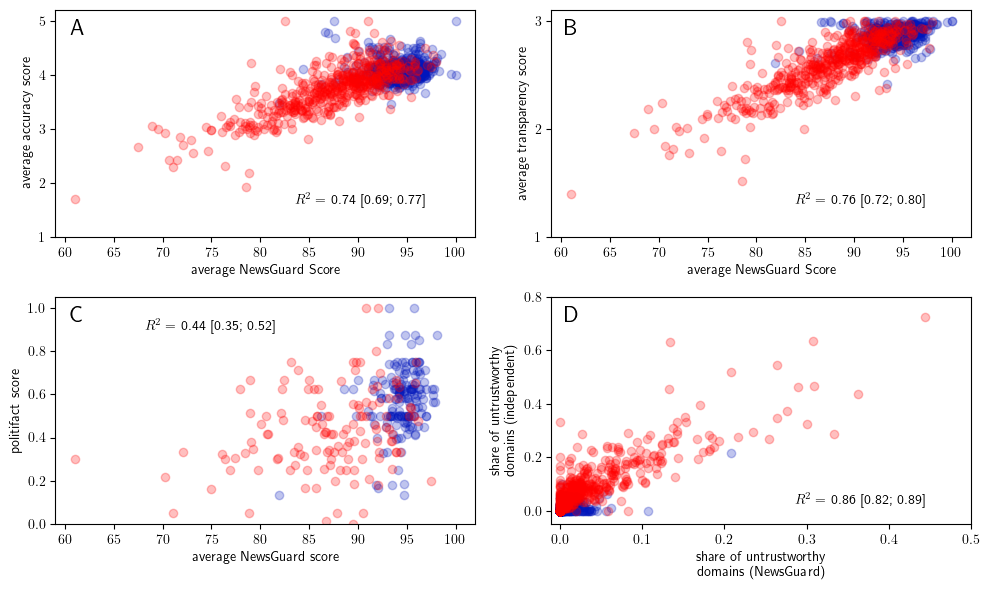

In [26]:
fname = "SI_fig5"
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
dem = users[users["party"] == "Democrat"]
rep = users[users["party"] == "Republican"]
ax = axes[0][0]
ax.scatter(dem["NG_score_mean"], dem["accuracy_mean"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["accuracy_mean"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard Score")
ax.set_ylabel("average accuracy score")
ax.set_xlim(59, 102)
ax.set_ylim(1, 5.2)
ax.set_yticks([1, 2, 3, 4, 5])

ax = axes[0][1]
ax.scatter(dem["NG_score_mean"], dem["transparency_mean"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["transparency_mean"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard Score")
ax.set_ylabel("average transparency score")
ax.set_xlim(59, 102)
ax.set_ylim(1, 3.1)
ax.set_yticks([1, 2, 3])

ax = axes[1][0]
ax.scatter(dem["NG_score_mean"], dem["pf_score"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_score_mean"], rep["pf_score"], color=repred, alpha=0.25)
ax.set_xlabel("average NewsGuard score")
ax.set_ylabel("politifact score")
ax.set_xlim(59, 102)
ax.set_ylim(0, 1.05)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax = axes[1][1]
ax.scatter(dem["NG_unreliable_share"], dem["independent_unreliable_share"], color=demblue, alpha=0.25)
ax.scatter(rep["NG_unreliable_share"], rep["independent_unreliable_share"], color=repred, alpha=0.25)
ax.set_xlabel("share of untrustworthy\ndomains (NewsGuard)")
ax.set_ylabel("share of untrustworthy\ndomains (independent)")
ax.set_xlim(-0.01, 0.5)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylim(-0.05, 0.8)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

fig.text(0.3, 0.65, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_accuracy"].mean(),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.025),
        pf_bootstrap["corr_NGScore_accuracy"].quantile(0.975)))

fig.text(0.8, 0.65, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_transparency"].mean(),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.025),
        pf_bootstrap["corr_NGScore_transparency"].quantile(0.975)))

fig.text(0.15, 0.44, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGScore_pf"].mean(),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.025),
        pf_bootstrap["corr_NGScore_pf"].quantile(0.975)))

fig.text(0.8, 0.15, "$R^2 =$ {:1.2f} [{:1.2f}; {:1.2f}]".format(\
        pf_bootstrap["corr_NGShare_ind"].mean(),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.025),
        pf_bootstrap["corr_NGShare_ind"].quantile(0.975)))

fig.text(0.075, 0.933, "A", fontsize=16)
fig.text(0.57, 0.933, "B", fontsize=16)
fig.text(0.075, 0.455, "C", fontsize=16)
fig.text(0.57, 0.455, "D", fontsize=16)

fig.tight_layout()
plt.savefig(join(dst, fname + ".png"), bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".pdf"),bbox_inches="tight", facecolor="white")
plt.savefig(join(dst, fname + ".svg"),bbox_inches="tight", facecolor="white")